In [307]:
import pandas as pd
import os
import numpy as np
import h5py

The training loop

Using the actual dataset from the matlab file given instead.

In [308]:
mat_file = "original_dataset/ReadBrownDwarf.mat"
data_path = "original_dataset/"
idTE = np.load(data_path + "idTE.npy")
idTR = np.load(data_path + "idTR.npy")
labelTE = np.load(data_path + "labelTE.npy")
labelTR = np.load(data_path + "labelTR.npy")

In [309]:
#Extracting the data from the mat file
with h5py.File(mat_file, 'r') as f:
    data = f["data"]
    data = pd.DataFrame(data).T
data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,326.808170,2.686124,5.5560,0.0000,5.7600,0.0000,5.9470,0.0000,6.0720,0.0000,...,0.162,0.050,0.015,0.044,5.562,5.539,5.479,0.017,0.026,0.020
1,321.200440,25.880459,0.0000,0.0000,7.6116,0.0010,0.0000,0.0000,7.5167,0.0010,...,0.059,0.020,0.016,0.059,6.896,6.921,6.932,0.026,0.024,0.016
2,144.038450,-12.459262,10.5120,0.0000,10.6920,0.0000,10.8660,0.0000,10.9890,0.0000,...,0.022,0.020,0.074,0.000,10.408,10.400,10.378,0.026,0.021,0.023
3,209.662170,21.696203,0.0000,0.0000,0.0000,0.0000,6.8603,0.1042,0.0000,0.0000,...,0.149,0.046,0.015,0.037,5.671,5.717,5.704,0.023,0.063,0.020
4,65.162550,-20.639620,0.0000,0.0000,0.0000,0.0000,6.3206,0.0000,5.9504,0.0031,...,0.169,0.072,0.015,0.036,5.430,5.402,5.333,0.054,0.036,0.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664,13.245956,49.443574,9.1227,0.2347,9.1823,0.0010,0.0000,0.0000,9.0066,0.0010,...,0.022,0.019,0.021,0.144,8.358,8.389,8.398,0.027,0.017,0.016
5665,29.647854,48.432832,0.0000,0.0000,9.5538,0.0010,0.0000,0.0000,10.7253,0.0010,...,0.023,0.019,0.026,0.297,8.778,8.804,8.766,0.021,0.016,0.020
5666,346.990957,54.326940,0.0000,0.0000,9.8405,0.0010,9.2025,0.0010,10.1089,0.0374,...,0.024,0.020,0.030,0.327,9.180,9.187,9.180,0.021,0.020,0.022
5667,331.173131,46.427253,10.4915,0.0630,10.2538,0.0239,10.0057,0.0074,10.4418,0.0315,...,0.023,0.020,0.033,0.000,9.693,9.678,9.622,0.024,0.029,0.023


In [310]:
data = pd.DataFrame(data.replace(0, data.mean()), columns=data.columns)

In [311]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []
for i in range(len(idTR)):
    X_train_list.append(data.iloc[idTR[i] - 1]) #idTR is 1 indexed
    X_test_list.append(data.iloc[idTE[i] - 1])  #idTE is 1 indexed
    y_train_list.append(labelTR[i])
    y_test_list.append(labelTE[i])

X_train_arr = np.array(X_train_list)
X_test_arr = np.array(X_test_list)
y_train_arr = np.array(y_train_list)
y_test_arr = np.array(y_test_list)

In [312]:
from sklearn.decomposition import PCA

pca = PCA(n_components=13)

X_train_arr_reshaped = X_train_arr.reshape(-1,26)
X_test_arr_reshaped = X_test_arr.reshape(-1,26)
print(X_train_arr_reshaped.shape)

pca.fit(X_train_arr_reshaped)
X_train_arr = pca.transform(X_train_arr_reshaped)
X_test_arr = pca.transform(X_test_arr_reshaped)
X_train_arr = X_train_arr.reshape(5,4535,13)
X_test_arr = X_test_arr.reshape(5,1134,13)

# X_train, X_test

(22675, 26)


In [313]:
X_train_arr.shape, X_test_arr.shape, y_train_arr.shape, y_test_arr.shape

((5, 4535, 13), (5, 1134, 13), (5, 4535), (5, 1134))

Neural Net for binary classification 5x32x64x32x1

# NN

In [314]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Convert numpy arrays or pandas DataFrames to PyTorch tensors if needed
X_train_tens = torch.tensor(X_train_arr, dtype=torch.float32)
y_train_tens = torch.tensor(y_train_arr, dtype=torch.long)

# Defining a simple neural network class for binary classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, activation):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.activation = activation       # Arbitrary activation function
        self.fc2 = nn.Linear(32, 64)
        # self.fc3 = nn.Linear(64, 32)  
        self.fc4 = nn.Linear(64, 1)# Output layer with single neuron (binary classification)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        # x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Apply sigmoid activation for binary classification of final output
        return x


In [316]:

losses = [] #Might turn into dict to make it more readable
for i in range(len(X_train_tens)):
    # Initialize the neural network
    input_size = X_train_tens[i].shape[1]
    model = NeuralNet(input_size, nn.ReLU())
    if i > 0:
        model.load_state_dict(torch.load(f'models/fold{i-1}_binary_classification_model.pth'))

    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters())

    # Prepare data for training using DataLoader
    batch_size = 32
    train_dataset = TensorDataset(X_train_tens[i], y_train_tens[i])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    num_epochs = 15
    temp_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze(dim=1)  # Remove extra dimension for binary classification
            loss = criterion(outputs, labels.float())  # Calculate loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        temp_loss.append(running_loss / len(train_loader))
    losses.append(temp_loss)

    # Example: Make predictions
    # Assuming X_test is your test data
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        predictions = model(X_train_tens[i])
        predictions = (predictions > 0.5).int()  # Convert probabilities to binary predictions (0 or 1)

    # Define the directory path
    dir_path = './models/'
    
    # Check if the directory exists
    if not os.path.exists(dir_path):
        # If not, create the directory
        os.makedirs(dir_path)

    #Saving model for later use
    model_dir = './models/'
    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    model_path = os.path.join(model_dir, f'fold{i}_binary_classification_model.pth')
    torch.save(model.state_dict(), model_path)
    if i == 3:
        torch.save(model.state_dict(), 'binary_classification_model_iter3.pth')

Epoch 1, Loss: 0.3363059485252474
Epoch 2, Loss: 0.10168560805507529
Epoch 3, Loss: 0.08467291102705288
Epoch 4, Loss: 0.07706864334275605
Epoch 5, Loss: 0.07659240220804554
Epoch 6, Loss: 0.07214852349675248
Epoch 7, Loss: 0.06947175064780028
Epoch 8, Loss: 0.06497079952501915
Epoch 9, Loss: 0.0601278015012315
Epoch 10, Loss: 0.057780441085309525
Epoch 11, Loss: 0.05457999380338203
Epoch 12, Loss: 0.05376288813578201
Epoch 13, Loss: 0.05286174565455286
Epoch 14, Loss: 0.05025006384706833
Epoch 15, Loss: 0.04717739844779995
Epoch 1, Loss: 0.05346945000969818
Epoch 2, Loss: 0.050855741800058266
Epoch 3, Loss: 0.050478109734093536
Epoch 4, Loss: 0.045830994880509
Epoch 5, Loss: 0.045399443187396714
Epoch 6, Loss: 0.046187546714143435
Epoch 7, Loss: 0.04680558445151817
Epoch 8, Loss: 0.043382067303829104
Epoch 9, Loss: 0.04243167042141964
Epoch 10, Loss: 0.04390939317961735
Epoch 11, Loss: 0.04111215229388851
Epoch 12, Loss: 0.042396207930336535
Epoch 13, Loss: 0.04134820276563069
Epoch 1

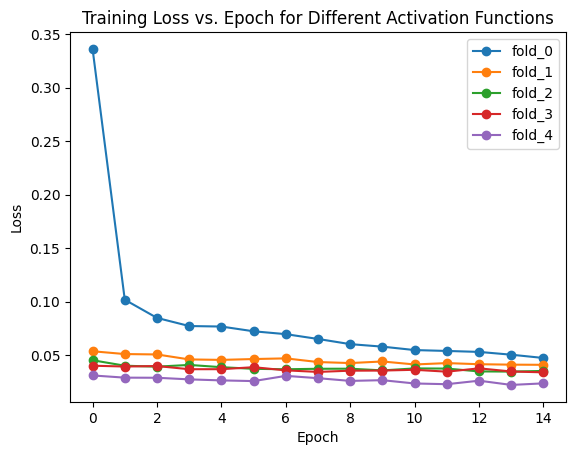

In [317]:
import matplotlib.pyplot as plt
for i, loss in enumerate(losses):
    # c = act_colors[f"fold_{i}"]
    plt.plot(loss, "-o", label=f"fold_{i}")#, color = c)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch for Different Activation Functions")
plt.show()

In [318]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

for i in range(len(X_train_tens)):
    print(f"Evaluating model on fold: {i}")
    # Load the trained model
    input_size = input_size  # Assuming the input size based on X_train
    model = NeuralNet(input_size, nn.ReLU())
    # model.load_state_dict(torch.load('./models/binary_classification_model.pth'))  # Load the trained model state  (Windows)
    model.load_state_dict(torch.load(f'models/fold{i}_binary_classification_model.pth'))  # Load the trained model state (MACos)


    # Assuming X_test and y_test are your test data
    X_train = X_train_tens[i].float()
    y_train = y_train_tens[i].float()

    # Prepare test dataset and dataloader
    batch_size = 64
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    # Evaluate the model on the test set using F1 score
    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    #print(test_loader)
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc_tr = matthews_corrcoef(y_true, y_pred)

    

    print(f"Training: MCC-score: {mcc_tr}, check against the test set for overfitting")


Evaluating model on fold: 0
Training: MCC-score: 0.9701142251370646, check against the test set for overfitting
Evaluating model on fold: 1
Training: MCC-score: 0.971830087190055, check against the test set for overfitting
Evaluating model on fold: 2
Training: MCC-score: 0.9795236407292204, check against the test set for overfitting
Evaluating model on fold: 3
Training: MCC-score: 0.9737681270095312, check against the test set for overfitting
Evaluating model on fold: 4
Training: MCC-score: 0.979558222018525, check against the test set for overfitting


### Testing the model on the test set

In [325]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix


all_metrics = {}
all_confusion_matrices = {}
for i in range(len(X_train_tens)):
    print(f"Evaluating model on fold: {i}")
    # Load the trained model
    input_size = input_size  # Assuming the input size based on X_train
    model = NeuralNet(input_size, nn.ReLU())
    # model.load_state_dict(torch.load('./models/binary_classification_model.pth'))  # Load the trained model state  (Windows)
    model.load_state_dict(torch.load(f'models/fold{i}_binary_classification_model.pth'))  # Load the trained model state (MACos)


    # Assuming X_test and y_test are your test data
    X_test = torch.tensor(X_test_arr[i], dtype=torch.float32)
    y_test = torch.tensor(y_test_arr[i], dtype=torch.float32)

    # Prepare test dataset and dataloader
    batch_size = 64
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    # Evaluate the model on the test set using F1 score
    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    #print(test_loader)
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    #print(f"F1 Score: {f1}")

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    #print("Matthews Correlation Coefficient (MCC):", mcc)

    # Compute accuracy, precision and recall
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')  # Change average as needed
    recall = recall_score(y_true, y_pred, average='binary')  # Change average as needed

    #print("Accuracy:", accuracy)
    #print("Precision:", precision)
    #print("Recall:", recall)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1,0])
    #print("Confusion Matrix:", conf_matrix)

    # Store the metrics in a dictionary for easy plotting
    metrics = {'F1 Score': f1, 'MCC': mcc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    
    all_metrics[f"fold_{i}"] = metrics
    all_confusion_matrices[f"fold_{i}"] = conf_matrix
    print(f"Testing: {metrics['MCC']}")

    # Define the directory path
    dir_path = './models/'
    
    # Check if the directory exists
    if not os.path.exists(dir_path):
        # If not, create the directory
        os.makedirs(dir_path)

    # Save the model
    model_path = os.path.join(dir_path, f'fold{i}_binary_classification_model.pth')
    torch.save(model.state_dict(), model_path)

Evaluating model on fold: 0
Testing: 0.9673819604992024
Evaluating model on fold: 1
Testing: 0.9783108909008705
Evaluating model on fold: 2
Testing: 0.9696771243202427
Evaluating model on fold: 3
Testing: 0.9849760661619122
Evaluating model on fold: 4
Testing: 0.9639492667896695


(0.6, 1.0)

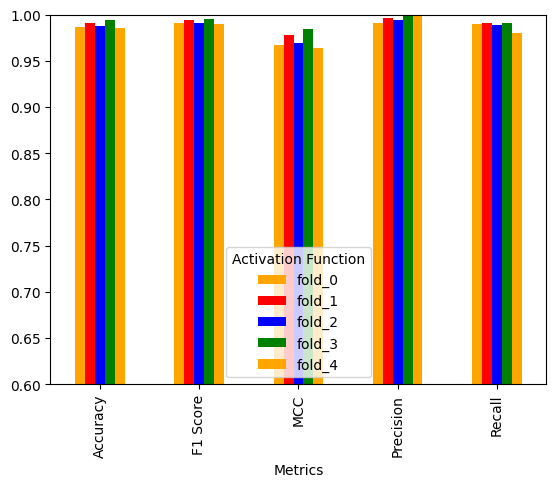

In [326]:
# Convert the all_metrics dictionary to a DataFrame
data = pd.DataFrame(all_metrics)
# Reset the index to make 'Metrics' a column
data = data.reset_index().rename(columns={'index': 'Metrics'})


data = pd.melt(data, id_vars='Metrics', var_name='Activation Function', value_name='Value')

data = data.set_index(['Metrics', 'Activation Function']).Value
# colors = [act_colors[act_name] for act_name in all_metrics.keys()]
colors = ["orange", "red", "blue", "green"]
data.unstack().plot(kind='bar', stacked=False, color = colors)
plt.ylim(0.6,1)

In [327]:
print(len(y_test[y_test == 0]))
print(len(y_test[y_test == 1]))

319
815


## Confusion matrix comparison

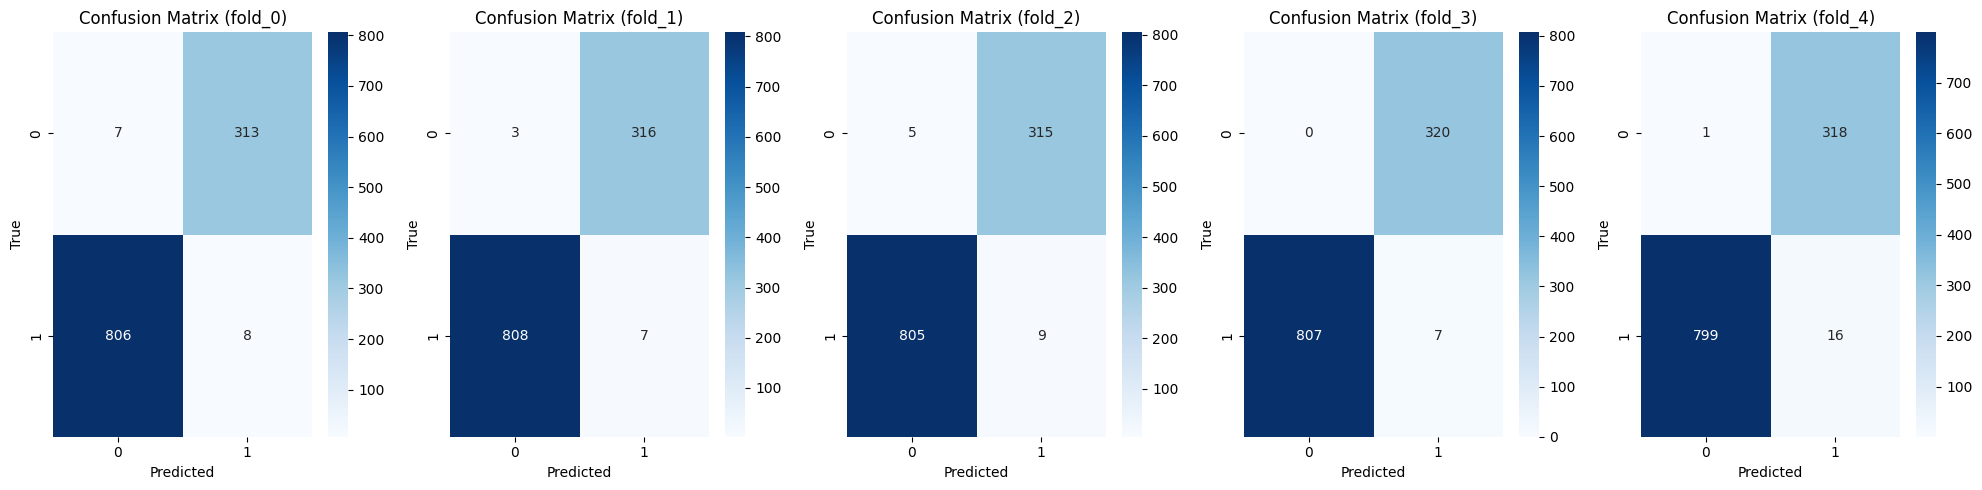

In [329]:
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(len(X_train_tens)):
    # Assume you have a function `get_conf_matrix` that returns the confusion matrix for a given activation function
    conf_matrix = all_confusion_matrices[f"fold_{i}"]

    # Create a heatmap for the confusion matrix on the i-th subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])

    # Set the title, x-label, and y-label for the i-th subplot
    axes[i].set_title(f'Confusion Matrix (fold_{i})')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()